In [28]:
import seir_discrete 
import pandas as pd
import numpy as np
import os
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error
from scipy.optimize import curve_fit
import time
import tkinter as tk
from tkinter import messagebox
import math
import warnings
warnings.filterwarnings(action='ignore')

In [29]:
def plot_one(ax, start_day, 
             predicted_days, seed_data, predicted_I, predicted_beta,
             seed, execution_time):
    '''
    Рисуем график для одного сида.
    
    Параметры:

    - ax -- область для графика
    - start_day -- день переключения на СИИР модель
    - predicted_days -- дни прогноза
    - seed_data -- датафрейм сида от регулярной сети
    - predicted_I -- смоделированная траектория компартмента Infected
    - predicted_beta -- смоделированная/спрогнозированная бета
    - seed -- номер сида        
    - execution_time - время моделирования Beta   
    '''
    
    actual_I = seed_data.iloc[start_day:]['I'].values 
    #n = len(predicted_I.shape[1])
    rmse_I = root_mean_squared_error(actual_I, predicted_I[0])

    actual_Beta = seed_data.iloc[start_day:]['Beta'].values 
    #n_beta = len(predicted_beta)
    rmse_Beta = root_mean_squared_error(actual_Beta, predicted_beta)   

    # день перехода
    ax.axvline(start_day, color='red',ls=':')
    # реальные I, смоделированные I
    ax.plot(seed_data.index, seed_data.iloc[:]['I'].values , color='tab:blue', label='Actual I')
    ax.plot(predicted_days, predicted_I[0],color='blue', ls='--', 
                alpha=0.9, label='Predicted I (det.)')
    
    # для стохастической С(И)ИР строим 15 траекторий
    for i in range(predicted_I.shape[0]-1):
        if i==0:
            label='Predicted I (stoch.)'
        else:
            label=''
            
        ax.plot(predicted_days, predicted_I[i+1], color='tab:blue', ls='--', 
                alpha=0.3, label=label)
    ax.set_xlabel('Days')
    ax.set_ylabel('Infected', color='blue')
    ax.grid(True, alpha=0.3)
        
    ax_b = ax.twinx()
    # реальная beta, смоделированная beta
    ax_b.plot(seed_data.index, seed_data['Beta'],  color='gray', ls='--', alpha=0.4, label='Actual Beta')
    ax_b.plot(predicted_days, predicted_beta,color='coral', ls='--', alpha=0.7,label='Predicted Beta ')

    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax_b.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    ax.set_title(f'Seed {seed}, \n'+
                 f'RMSE I:{rmse_I:.2f}, RMSE beta:{rmse_Beta:.2e}, \n'+
                 f'Time: {execution_time:.2e}' ,fontsize=10)
    
def load_saved_model(model_path):
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file not found at {model_path}")
    return joblib.load(model_path)

def predict_beta(I_prediction_method, given_betas, beta_prediction_method, predicted_days):
    '''
    Моделируем/прогнозируем бету.

    Параметры:

    - I_prediction_method -- математическая модель для построения траектории Infected
        ['seir', 'sir']
    - given_betas -- бета, которая подается для прогноза
    - beta_prediction_method -- метод прогноза беты
        ['bi_exp_decay', 'polynom', 'percentiles']
    - predicted_days -- дни прогноза 
    '''
    if beta_prediction_method == 'bi_exp_decay':
        def bi_exp_decay_func(x,a,b,c): 
            return a*(np.exp(-b*x) - (np.exp(-c*x)))
        given_days = np.arange(given_betas.shape[0])
        coeffs, _ = curve_fit(bi_exp_decay_func, given_days, given_betas)
        predicted_betas = bi_exp_decay_func(predicted_days, *coeffs)
        predicted_betas[predicted_betas < 0] = 0
        
    elif beta_prediction_method == 'polynom':
        if I_prediction_method == 'seir':
            model_path = 'seir_model.joblib'
        else: 
            model_path = 'sir_model.joblib'
        # загрузка модели с функции ЭлизабЭтти
        model = load_saved_model(model_path)
        # прогнозируем бету на все оставшиеся дни
        log_beta = model.predict(predicted_days.reshape(-1,1))
        predicted_betas = np.exp(log_beta)
        
    elif beta_prediction_method == 'percentiles':
        # заглушка
        predicted_betas = [0 for i in predicted_days]
    
    return predicted_betas 

def predict_I(I_prediction_method, y, start_day, predicted_days, predicted_beta, sigma, gamma, stype):
    if I_prediction_method == 'seir':

        S,E,I,R = seir_discrete.seir_model(y, start_day, predicted_days, 
                            predicted_beta, sigma, gamma, 
                            stype, beta_t=True).T
    else:
        S,I,R = seir_discrete.sir_model(y, start_day, predicted_days, 
                            predicted_beta, gamma, 
                            stype, beta_t=True).T
    return I

def main_f(I_prediction_method, stochastic, count_stoch_line, beta_prediction_method, start_day, seed_numbers):
    '''
    Общая функция для построения графиков.
    
    Параметры:
    
    - I_prediction_method -- математическая модель для построения траектории Infected
        ['seir', 'sir']
    - stochastic -- присутствуют ли траектории стохастической модели СИИР 
        (траектории детерминированной присутствуют по умолчанию)
    - count_stoch_line -- количество траекторий стохастической модели СИИР
    - beta_prediction_method -- метод прогноза беты
        ['bi_exp_decay', 'polynom', 'percentiles']
    - start_day -- день переключения на СИИР модель
    - seed_numbers -- номера сидов
    
    Выход:
        График для сидов.
    '''
    # всегда постоянные
    sigma = 0.1
    gamma = 0.08
    
    fig, axes = plt.subplots(len(seed_numbers)//2+math.ceil(len(seed_numbers)%2), 2, figsize=(15, 20))
    axes = axes.flatten()
    
    seed_dirs=f'{I_prediction_method}_30_seeds_v0/'

    for idx, seed in enumerate(seed_numbers):
        
        # читаем данные сида: S,[E],I,R,Beta
        seed_data = pd.read_csv(seed_dirs + f'{I_prediction_method}_seed_{seed}.csv')
        seed_data = seed_data[pd.notna(seed_data['Beta'])]

        # дни для составления прогноза
        predicted_days = np.arange(start_day, seed_data.shape[0])
        
        # прогнозируем бета
        given_betas = seed_data.iloc[:start_day]['Beta'].values 
        start_time = time.time()
        predicted_beta = predict_beta(I_prediction_method, given_betas, beta_prediction_method, predicted_days)
        end_time = time.time()
        execution_time = end_time - start_time

        # берем значения компартментов в день переключения
        y = seed_data.iloc[start_day].drop('Beta')

        predicted_I = np.zeros((count_stoch_line+1, predicted_days.shape[0]))
        # передаем в соответствующую С(И)ИР модель (стохастическую или детерм.)
        # если I_prediction_method == ... , если stochastic == ...
        predicted_I[0] = predict_I(I_prediction_method, y, start_day, predicted_days, predicted_beta, sigma, gamma, 'det')
        if stochastic:
            for i in range(count_stoch_line):
                predicted_I[i+1] = predict_I(I_prediction_method, y, start_day, predicted_days, predicted_beta, sigma, gamma, 'stoch')

        ax = axes[idx]
        # строим один график
        plot_one(ax, start_day, predicted_days, seed_data, predicted_I, predicted_beta, seed, execution_time)        
    
    
    # Добавление общего заголовка
    fig.suptitle(f'Switch {start_day} day, \n'+
                 f'I_prediction_method:{I_prediction_method}, \n'+
                 f'beta_prediction_method: {beta_prediction_method}' ,fontsize=15)
    plt.tight_layout()
    plt.show()   

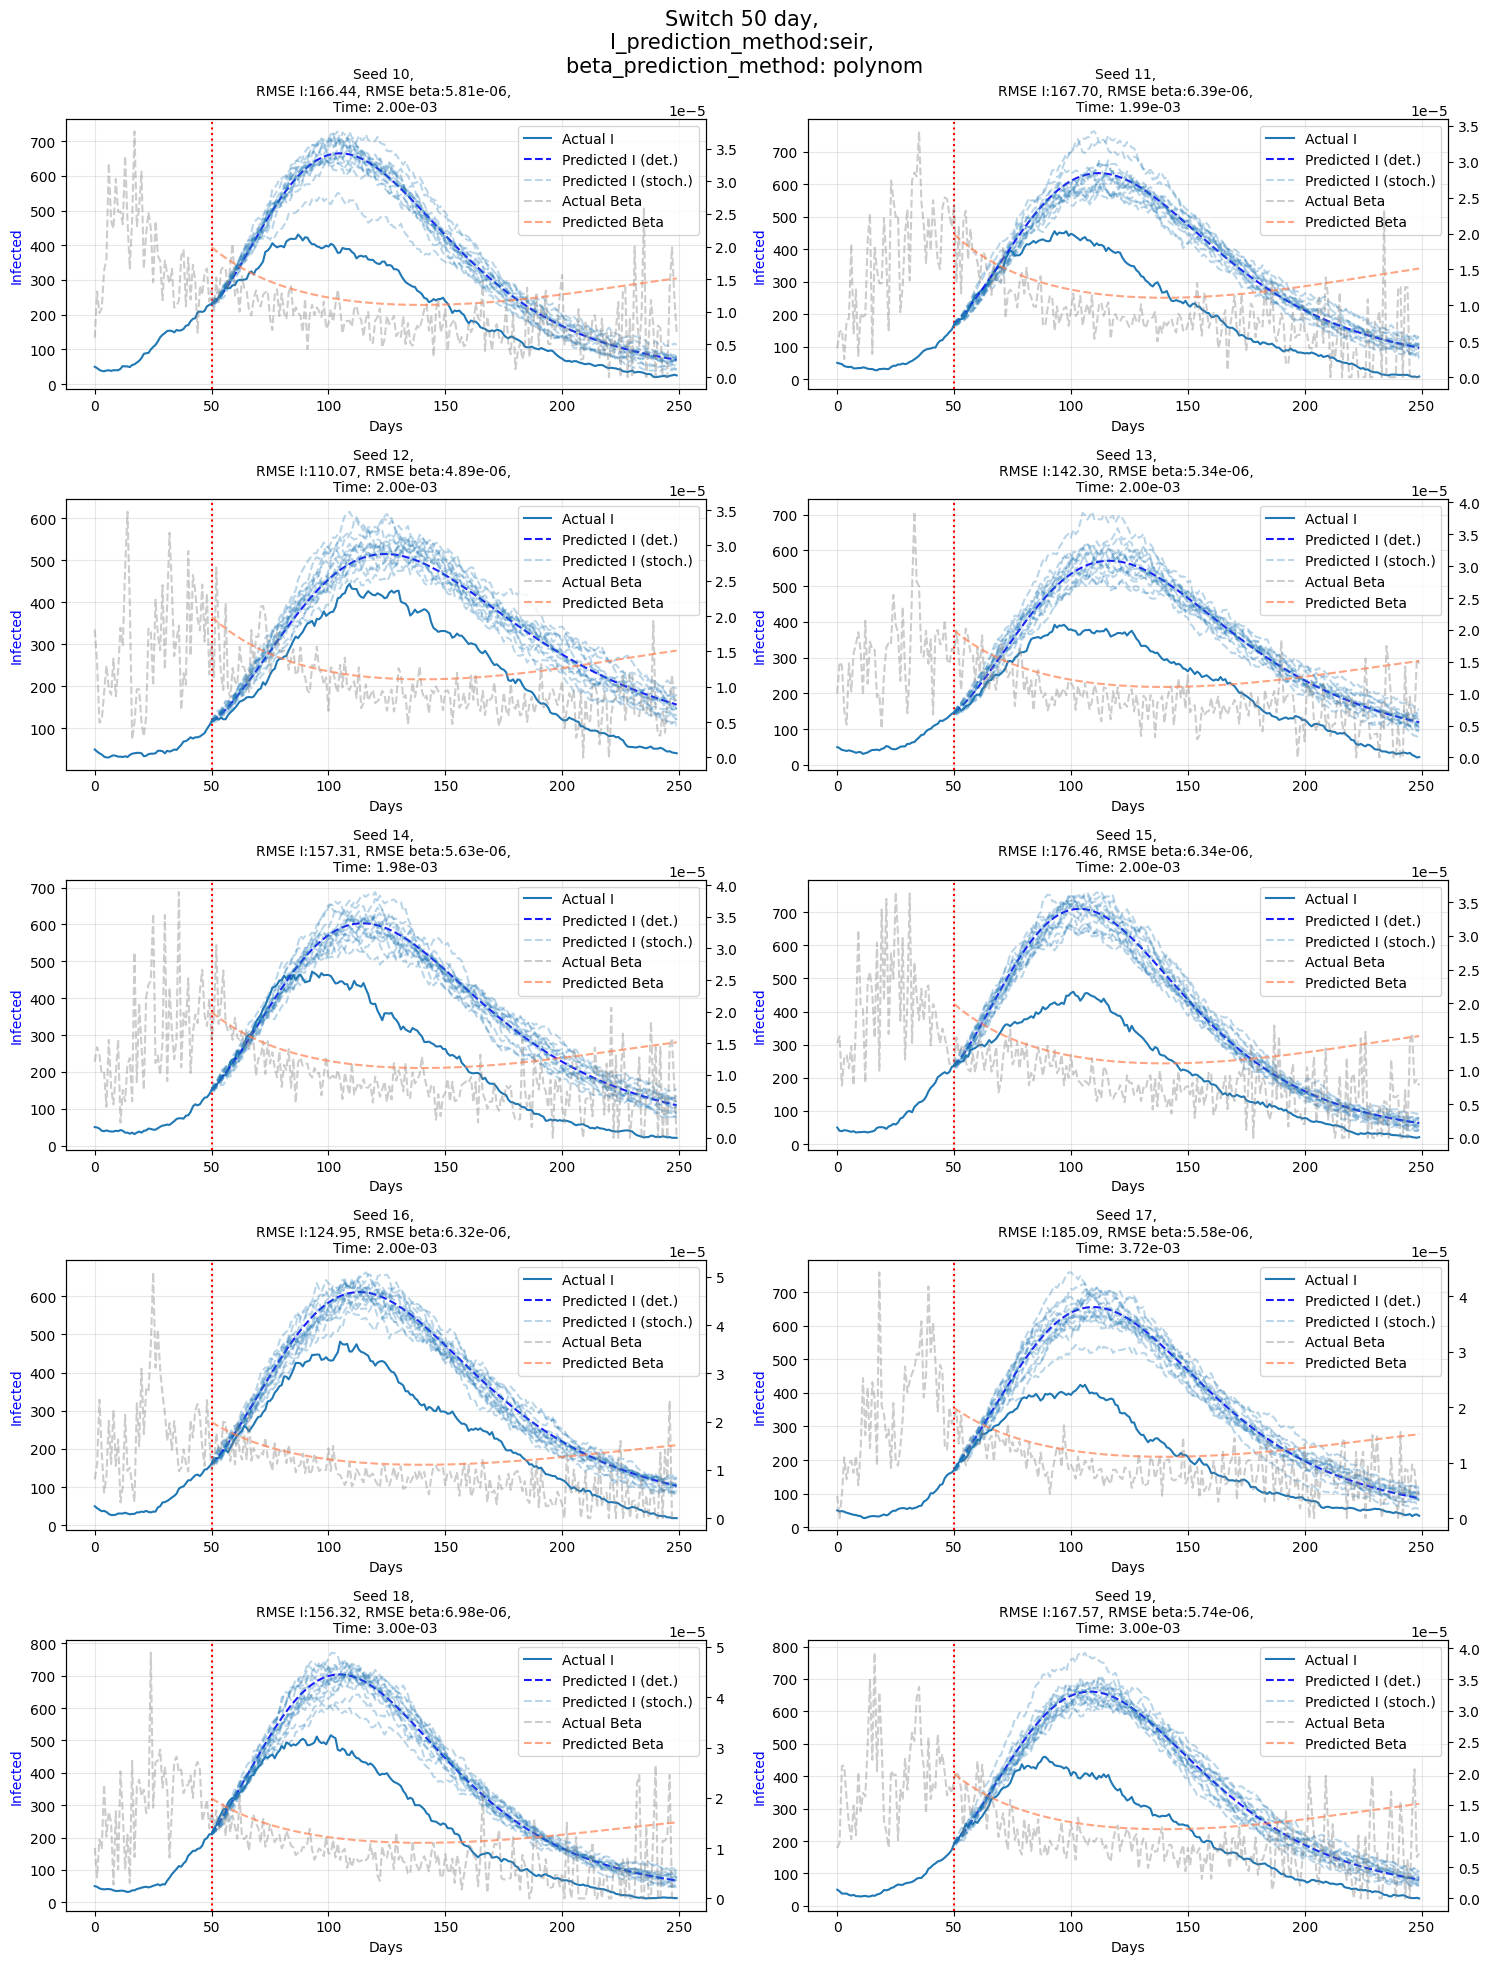

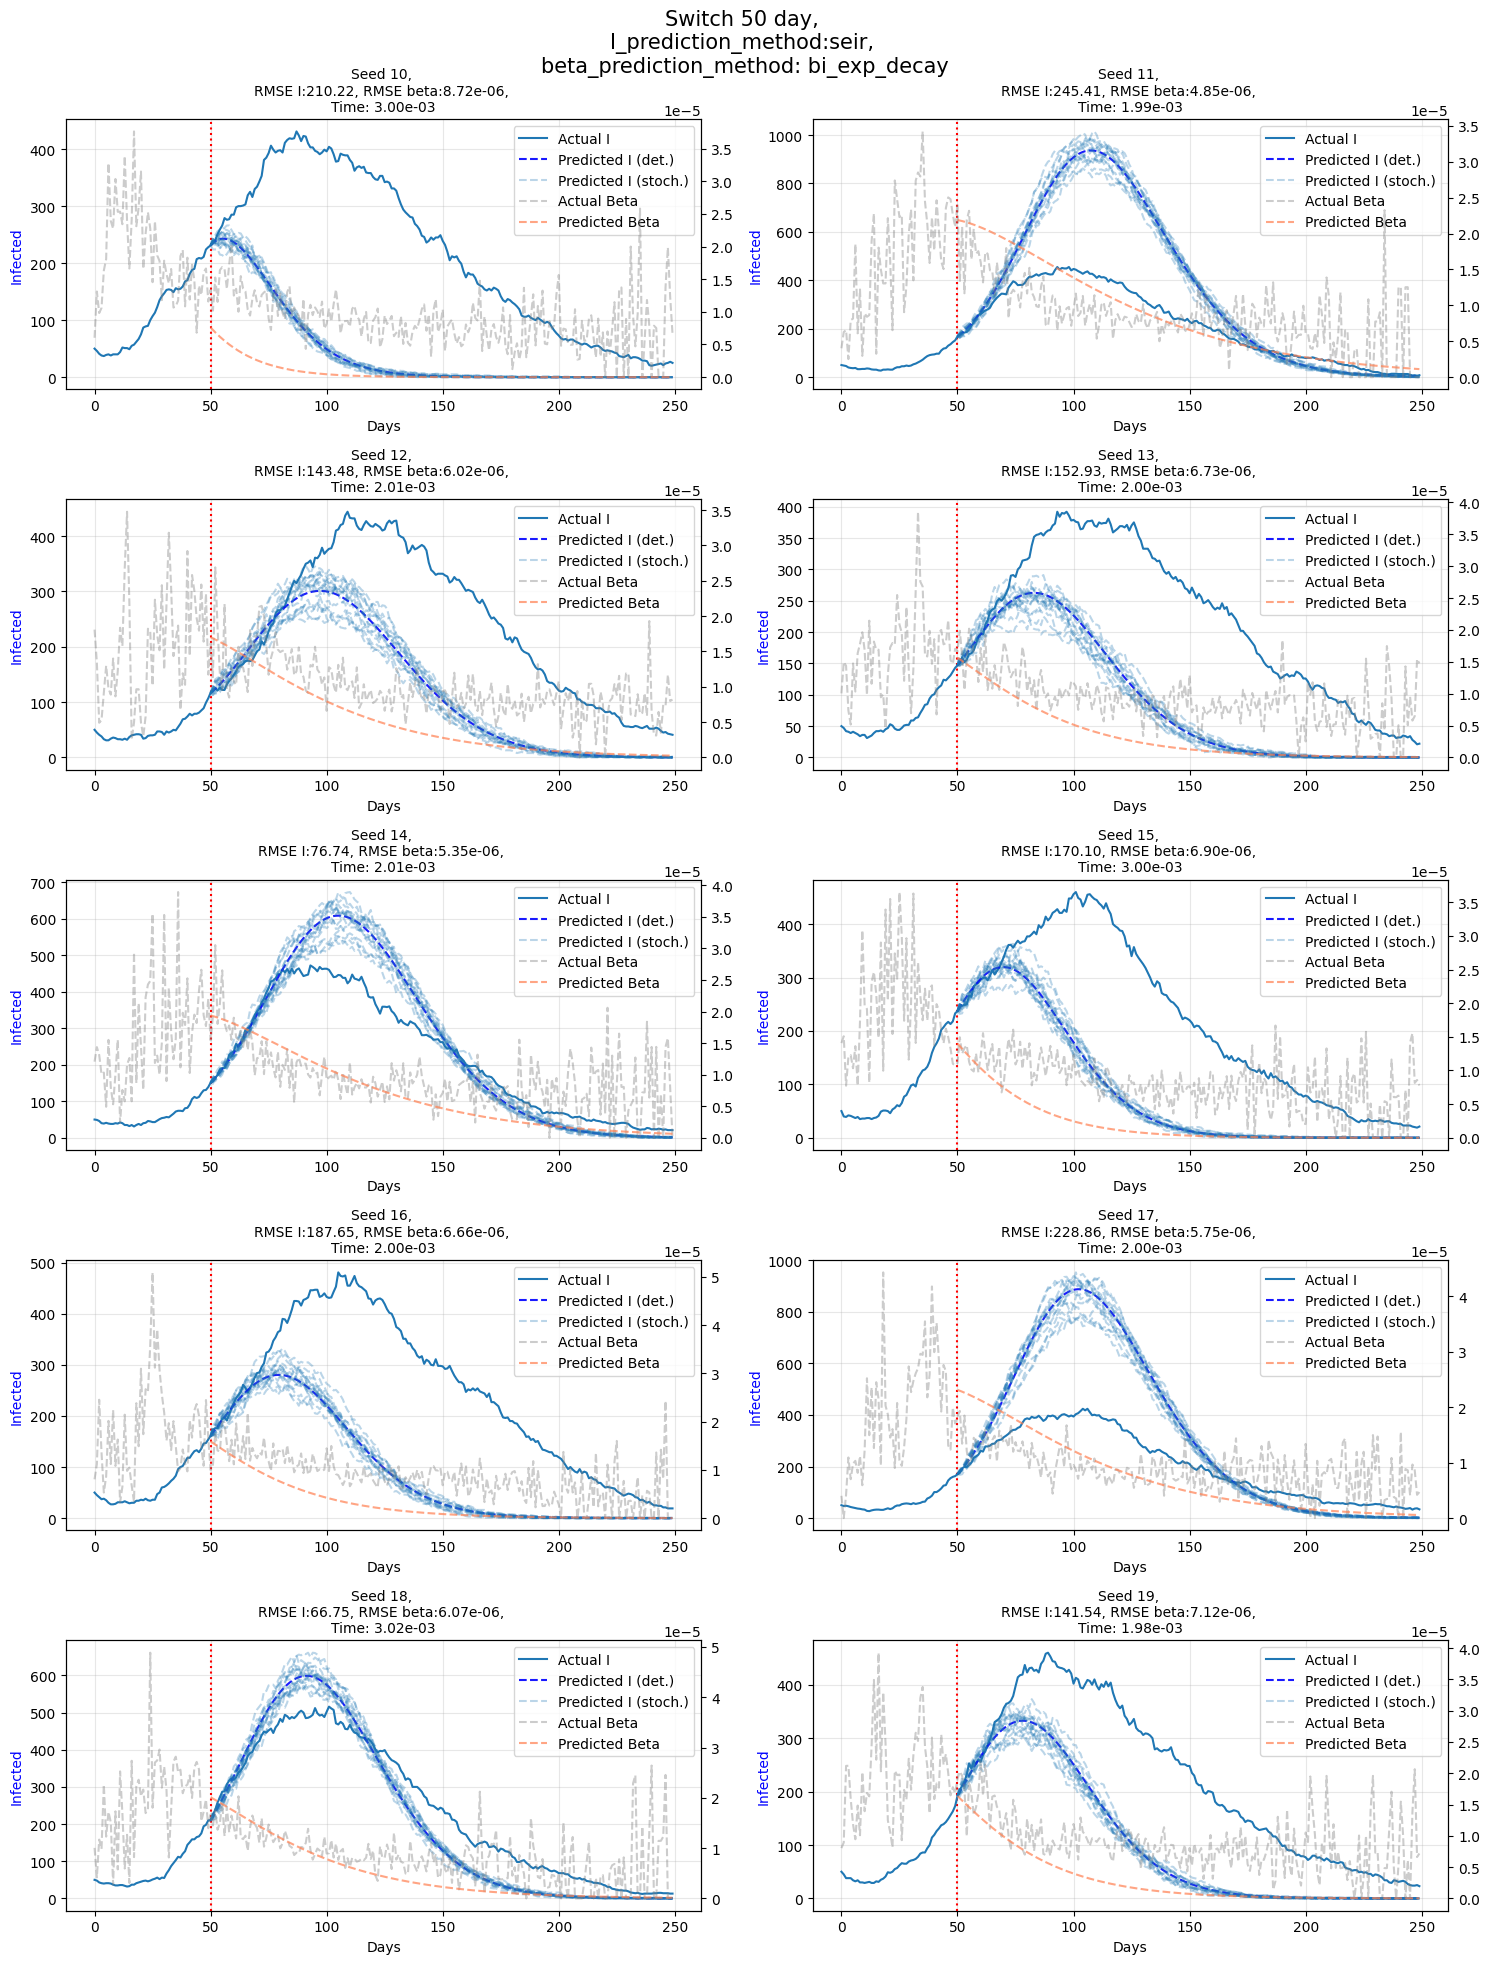

In [30]:
'''
создаем графическое окошко для ввода параметров
'''
def parse_seeds(seeds_input):
    seeds = set()  # Используем множество для уникальных значений
    parts = seeds_input.split(',')
    
    for part in parts:
        if '-' in part:  # Если есть тире, значит это диапазон
            start, end = part.split('-')
            seeds.update(range(int(start), int(end)))  # Добавляем все числа в диапазоне (включительно)
        else:
            seeds.add(int(part))  # Добавляем отдельное семя
            
    return sorted(seeds)  # Возвращаем отсортированный список

def calculate():
    try:
        # Получаем значения из полей ввода
        I_prediction_method = var_I_prediction_method.get()
        stochastic = var_stochastic.get()
        
        # Получаем количество случайных траекторий только если стохастичность включена
        count_stoch_line = int(entry_count_stoch_line.get()) if stochastic else 0
        
        beta_prediction_method = var_beta_prediction_method.get()
        start_day = int(entry_start_day.get())
        seed_numbers = entry_seed_numbers.get()

        # Парсим семена
        seed_numbers = parse_seeds(seed_numbers)
        
        # Вызываем основную функцию
        result = main_f(I_prediction_method, stochastic, count_stoch_line, beta_prediction_method, start_day, seed_numbers)
        
        # Выводим результат
        messagebox.showinfo("Результат", result)
    except ValueError:
        messagebox.showerror("Ошибка", "Пожалуйста, введите корректные данные.")
    except Exception as e:
        messagebox.showerror("Ошибка", f"Произошла ошибка: {str(e)}")

# Создаем главное окно
root = tk.Tk()
root.title("Ввод параметров")

# Создаем переменную для выбора мат. модели
var_I_prediction_method = tk.StringVar(value="seir")  # Устанавливаем значение по умолчанию

# Создаем выпадающий список для выбора мат. модели
label_I_prediction_method = tk.Label(root, text="Метод предсказания Infected:")
label_I_prediction_method.pack()

I_prediction_method_options = ["seir", "sir"]
dropdown_I_prediction_method = tk.OptionMenu(root, var_I_prediction_method, *I_prediction_method_options)
dropdown_I_prediction_method.pack()

# Создаем флажок для стохастичности
var_stochastic = tk.BooleanVar(value=False)
checkbox_stochastic = tk.Checkbutton(root, text="Стохастичность", variable=var_stochastic, command=lambda: toggle_stochastic_entry())
checkbox_stochastic.pack()

# Создаем метку и поле ввода для count_stoch_line
label_count_stoch_line = tk.Label(root, text="Количество случайных траекторий:")
label_count_stoch_line.pack()

entry_count_stoch_line = tk.Entry(root)
entry_count_stoch_line.pack()
entry_count_stoch_line.config(state='disabled')  # Изначально отключаем поле ввода

# Функция для включения/выключения поля ввода в зависимости от состояния флажка
def toggle_stochastic_entry():
    if var_stochastic.get():
        entry_count_stoch_line.config(state='normal')  # Включаем поле ввода
    else:
        entry_count_stoch_line.config(state='disabled')  # Отключаем поле ввода

# Создаем переменную для выбора модели прогнозирования beta
var_beta_prediction_method = tk.StringVar(value="polynom")  # Устанавливаем значение по умолчанию

# Создаем выпадающий список для выбора мат. модели
label_beta_prediction_method = tk.Label(root, text="Метод предсказания Beta:")
label_beta_prediction_method.pack()

beta_prediction_method_options = ['polynom', 'bi_exp_decay', 'percentiles']
dropdown_beta_prediction_method = tk.OptionMenu(root, var_beta_prediction_method, *beta_prediction_method_options)
dropdown_beta_prediction_method.pack()

# Создаем метку и поле ввода для start_day
label_start_day = tk.Label(root, text="День начала:")
label_start_day.pack()

entry_start_day = tk.Entry(root)
entry_start_day.pack()

# Создаем метку и поле ввода для seeds
label_seed_numbers = tk.Label(root, text="Seed_numbers (через запятую или диапазон через тире):")
label_seed_numbers.pack()

entry_seed_numbers = tk.Entry(root)
entry_seed_numbers.pack()

# Создаем кнопку для выполнения вычисления
button_calculate = tk.Button(root, text="Вычислить", command=calculate)
button_calculate.pack()

# Запускаем главный цикл приложения
root.mainloop()